# 데이터 분석

1. `모델이 잘 풀지 못하는 데이터 확인`

    - 모델별로 dev 데이터셋에 대한 라벨 예측 진행 후 오답 분석
        - dev 데이터셋에 대한 모델의 성능 평가를 위한 Confusion matrix

    - 오답 분석을 통한 모델별 장단점 파악
    
    - 특히 공통적으로 잘 못맞추는 `TOTAL`라벨을 보완하기 위한 `TOTAL` 데이터 분석
        - 잘 맞추는 `TOTAL`데이터 공통적인 특징
        - 잘 못맞추는 `TOTAL`데이터 공통적인 특징
        - 나머지 `TOTAL`데이터 공통적인 특징
        - 모든 `TOTAL`데이터 공통적인 특징

<br/>

2. `앞으로의 개선 방향 아이디어`

    - 왜 `TOTAL` 데이터를 잘 맞추지 못할까?
    - `TOTAL`을 잘 맞추기 위한 개선 방향

## 모델이 잘 풀지 못하는 데이터 확인

### 모델별로 dev 데이터셋에 대한 라벨 예측 진행 후 오답 분석

- 사용 모델

| Model | F1 | em | em_no_space | #Parameters | steps |
| --- | --- | --- | --- | --- | --- |
| `google-bert/bert-base-uncased` | 81.425 | 46.18 | 46.18 | 110M | 600 |
| `microsoft/layoutlm-base-uncased` | 82.77 | 50.36 | 50.36 | 113M | 600 |
| `microsoft/layoutlm-large-uncased` | **0.8506** | 49.63 | 49.63 | 343M | 600 |

#### dev 데이터셋에 대한 모델의 성능 평가를 위한 Confusion matrix

In [182]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import confusion_matrix
import seaborn as sns

from seqeval.metrics import f1_score, classification_report
import csv

In [183]:
dev_dir = './dev.csv'
output_dir = '../dev_outputs/layoutlm-large-dev.csv' # mode='dev' 로 놓고 학습된 모델로 inference.py를 실행하면 output.csv 파일이 생성됩니다 -> 이를 적절한 공간에 옮기고 경로를 설정해주세요

In [216]:
def confusion_matrix_graph(output_dir):
    """
    주어진 데이터프레임(df)의 'label'과 'pred_label' 열을 사용하여 confusion matrix을 계산하고
    heatmap 형태로 시각화합니다.

    arguments:
        output_dir: str - output.csv 파일의 경로
    
    return:
        None. 함수는 confusion matrix heatmap을 출력합니다.
    """
    df = pd.read_csv(output_dir, header=None)
    df.columns = ['word', 'pred_label','label']
    
    cm = confusion_matrix(df['label'], df['pred_label'])
    cmap = mcolors.ListedColormap(['white', '#B8C9F4', '#898FF5'])  

    bounds = [0.5, 1.0, 10.0, cm.max() + 0.5]  # 1.0, 10.0을 경계값으로 설정
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    labels = sorted(list(df['label'].unique()))

    # heatmap 그리기
    plt.figure(figsize=(6, 4))
    ax =sns.heatmap(cm, annot=True, annot_kws={"size":8}, cmap=cmap, norm=norm, fmt='g', xticklabels=labels, yticklabels=labels)

    # 축 이름 및 제목 설정
    ax.set_yticklabels(labels, rotation=0, fontsize=6)
    ax.set_xticklabels(labels, rotation=0, fontsize=6)
    plt.xlabel('Predicted Labels', fontsize=8)
    plt.ylabel('True Labels', fontsize=8)
    plt.title('*{}\'s Confusion Matrix'.format(output_dir.split('/')[-1][:-4]), fontsize=15, y=1.05)
    # 그래프 표시
    plt.show()


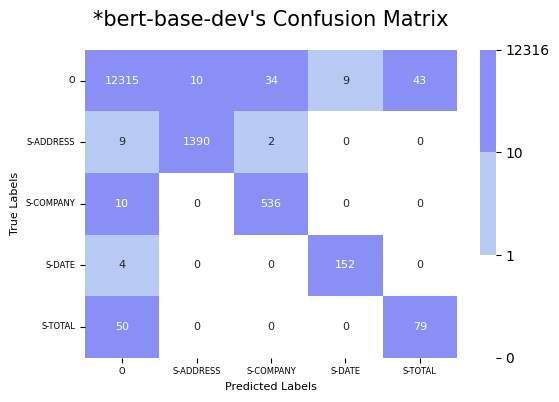

In [217]:
confusion_matrix_graph('../dev_outputs/bert-base-dev.csv')

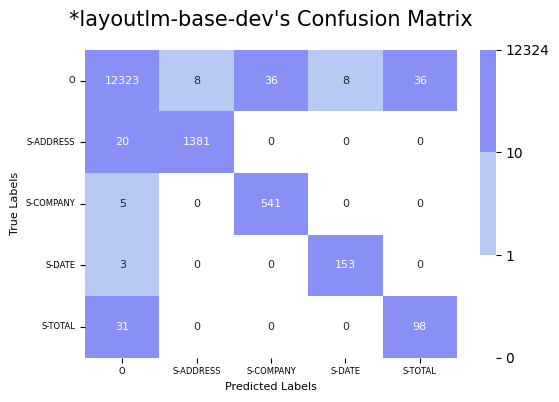

In [218]:
confusion_matrix_graph('../dev_outputs/layoutlm-base-dev.csv')

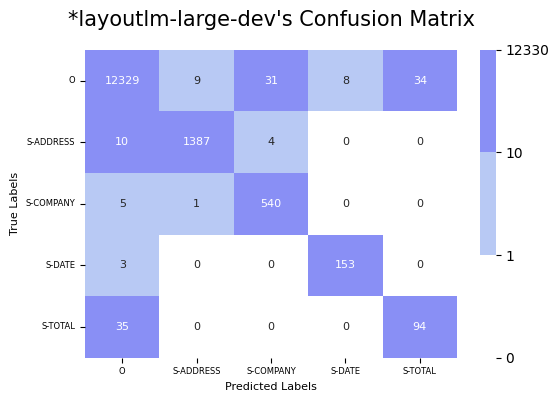

In [219]:
confusion_matrix_graph('../dev_outputs/layoutlm-large-dev.csv')

- `S-ADDRESS`와 `S-DATE`는 3개의 모델 모두 매우 잘 맞추는 편입니다

- `bert-base`에서 `layoutlm-base`로 넘어가면서 `S-ADDRESS`에 대한 성능 하락이 있었지만,\
`layoutlm-base`에서 `layoutlm-large`로 넘어가며 이 문제는 `bert-base` 수준으로 복원되었습니다

- 문제는, `S-TOTAL` 입니다

<br/>

#### [`text` - `predict_labels` - `target_labels` - `boxes` - `actual_boxes` - `file-name` - `f1_score`] 형태의 pandas.DataFrame을 만들어 분석 시작

- [inference.py](../inference.py)에 dev 데이터를 통한 예측 옵션 추가 (mode='dev')
    
- 위를 통해 얻어낸 [`word` - `predict` - `label`] DataFrame + [analysis_train_dev_split.ipynb](./analysis_train_dev_split.ipynb)에서 맨 마지막에 저장한 `dev.csv`\
     => [`text` - `predict_labels` - `target_labels` - `boxes` - `actual_boxes` - `file-name` - `f1_score`] DataFrame

In [6]:
dev_dir = './dev.csv'
output_dir = '../dev_outputs/bert-base-dev.csv' # mode='dev' 로 놓고 학습된 모델로 inference.py를 실행하면 output.csv 파일이 생성됩니다 -> 이를 적절한 공간에 옮기고 경로를 설정해주세요

In [100]:
dev_csv = pd.read_csv(dev_dir)
dev_csv.head()

,text,labels,boxes,actual_boxes,file_name,page_size
0,"['SYL', 'ROASTED', 'DELIGHTS', 'SDN.', 'BHD.',...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'S-COM...","[[101, 270, 179, 294], [187, 270, 370, 294], [...","[[63, 340, 112, 369], [117, 340, 231, 369], [2...",X51005337872,"[623, 1255]"
1,"['GARDENIA', 'BAKERIES', '(KL)', 'SDN', 'BHD',...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'S-COM...","[[54, 60, 230, 80], [238, 60, 414, 80], [422, ...","[[34, 72, 143, 96], [148, 72, 257, 96], [262, ...",X51006555817,"[620, 1200]"
2,"['POPULAR', 'BOOK', 'CO.', '(M)', 'SDN', 'BHD'...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'S-COM...","[[193, 46, 522, 70], [529, 46, 717, 70], [153,...","[[144, 102, 389, 154], [394, 102, 534, 154], [...",X51006008089,"[744, 2177]"
3,"['UNIHAKKA', 'INTERNATIONAL', 'SDN', 'BHD', '0...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'S-COM...","[[369, 244, 441, 254], [442, 244, 558, 254], [...","[[1834, 1713, 2190, 1786], [2195, 1713, 2773, ...",X51006414431,"[4961, 7016]"
4,"['AEON', 'CO.', '(M)', 'BHD', '(126926-H)', '3...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'S-COM...","[[264, 69, 345, 91], [352, 69, 412, 91], [419,...","[[187, 114, 244, 150], [249, 114, 291, 150], [...",X51005757235,"[706, 1640]"


In [4]:
def classification_report_column(row):
    return classification_report([eval(row['labels'])],[row['predict_labels']], output_dict=True)

def get_error_analysis_df(dev_dir, output_dir):
    dev_csv = pd.read_csv(dev_dir)
    samples = []

    # make a list of samples filled with list of predictions
    with open(output_dir) as f:
        reader = csv.reader(f)
        sample = []
        for row in reader:
            if row == [] or row == "\n":
                samples.append(sample)
                sample = []
            else:
                assert len(row) == 3
                sample.append(row[1])

    # add the predictions to the dev csv 
    dev_csv['predict_labels'] = samples

    # add a column for f1-score between target_labels and predict_labels
    dev_csv['classification_report'] = dev_csv.apply(classification_report_column, axis=1)

    # reordering columns and renaming them
    dev_csv = dev_csv[['text','predict_labels','labels','classification_report','boxes','actual_boxes','file_name','page_size']]
    dev_df = dev_csv.rename(columns={'text':'words','labels':'target_labels'})

    return dev_df


In [7]:
dev_df = get_error_analysis_df(dev_dir, output_dir)
dev_df.head()

c:\Users\user\anaconda3\envs\nlp1\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\anaconda3\envs\nlp1\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,words,predict_labels,target_labels,classification_report,boxes,actual_boxes,file_name,page_size
0,"['SYL', 'ROASTED', 'DELIGHTS', 'SDN.', 'BHD.',...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, S...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'S-COM...","{'ADDRESS': {'precision': 0.875, 'recall': 1.0...","[[101, 270, 179, 294], [187, 270, 370, 294], [...","[[63, 340, 112, 369], [117, 340, 231, 369], [2...",X51005337872,"[623, 1255]"
1,"['GARDENIA', 'BAKERIES', '(KL)', 'SDN', 'BHD',...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, S...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'S-COM...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[54, 60, 230, 80], [238, 60, 414, 80], [422, ...","[[34, 72, 143, 96], [148, 72, 257, 96], [262, ...",X51006555817,"[620, 1200]"
2,"['POPULAR', 'BOOK', 'CO.', '(M)', 'SDN', 'BHD'...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, S...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'S-COM...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[193, 46, 522, 70], [529, 46, 717, 70], [153,...","[[144, 102, 389, 154], [394, 102, 534, 154], [...",X51006008089,"[744, 2177]"
3,"['UNIHAKKA', 'INTERNATIONAL', 'SDN', 'BHD', '0...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, S...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'S-COM...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[369, 244, 441, 254], [442, 244, 558, 254], [...","[[1834, 1713, 2190, 1786], [2195, 1713, 2773, ...",X51006414431,"[4961, 7016]"
4,"['AEON', 'CO.', '(M)', 'BHD', '(126926-H)', '3...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, O...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'S-COM...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[264, 69, 345, 91], [352, 69, 412, 91], [419,...","[[187, 114, 244, 150], [249, 114, 291, 150], [...",X51005757235,"[706, 1640]"


### 모델별 샘플-level macro average f1-score가 0.75 미만인 샘플

## BERT
| Model | F1 | em | em_no_space | #Parameters | steps |
| --- | --- | --- | --- | --- | --- |
| `google-bert/bert-base-uncased` | 81.425 | 46.18 | 46.18 | 110M | 600 |

In [8]:
# mode='dev' 로 놓고 학습된 모델로 inference.py를 실행하면 output.csv 파일이 생성됩니다 -> 이를 적절한 공간에 옮기고 경로를 설정해주세요
output_dir = '../dev_outputs/bert-base-dev.csv' 
dev_df = get_error_analysis_df(dev_dir, output_dir)

c:\Users\user\anaconda3\envs\nlp1\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\anaconda3\envs\nlp1\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
# f1-score < 0.75
error_sample_df = dev_df[dev_df['classification_report'].apply(lambda x: x['macro avg']['f1-score']) < 0.75]
error_sample_df

,words,predict_labels,target_labels,classification_report,boxes,actual_boxes,file_name,page_size
0,"['SYL', 'ROASTED', 'DELIGHTS', 'SDN.', 'BHD.',...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, S...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'S-COM...","{'ADDRESS': {'precision': 0.875, 'recall': 1.0...","[[101, 270, 179, 294], [187, 270, 370, 294], [...","[[63, 340, 112, 369], [117, 340, 231, 369], [2...",X51005337872,"[623, 1255]"
9,"[""KING'S"", 'CONFECTIONERY', 'S/B', '273500-U',...","[S-COMPANY, S-COMPANY, S-COMPANY, O, O, S-ADDR...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'O', '...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[64, 128, 191, 151], [196, 128, 471, 151], [4...","[[57, 252, 169, 298], [174, 252, 417, 298], [4...",X51005719902,"[884, 1963]"
13,"['AMANO', 'MALAYSIA', 'SDN', 'BHD', '(682288-V...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, O...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'S-COM...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[15, 193, 150, 226], [160, 193, 377, 226], [3...","[[8, 209, 79, 244], [84, 209, 198, 244], [203,...",X51006387953,"[524, 1078]"
22,"['TAX', 'INVOICE', ""DONINO'S"", 'PIZZA', 'GST',...","[O, O, S-COMPANY, S-COMPANY, O, O, O, O, O, S-...","['O', 'O', 'S-COMPANY', 'S-COMPANY', 'O', 'O',...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[424, 135, 448, 144], [449, 135, 505, 144], [...","[[2108, 948, 2226, 1015], [2231, 948, 2507, 10...",X51006913074,"[4961, 7016]"
25,"['BROADVIEW', 'MARKETING', 'SDN', 'BHD(728384-...","[O, O, O, O, S-ADDRESS, S-ADDRESS, S-ADDRESS, ...","['O', 'O', 'O', 'O', 'S-ADDRESS', 'S-ADDRESS',...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[71, 163, 266, 185], [273, 163, 468, 185], [4...","[[50, 225, 186, 255], [191, 225, 327, 255], [3...",X51006392273,"[698, 1372]"
32,"['A', 'PIE', 'THING', 'FOUR', 'QUARTERS', 'SDN...","[O, O, O, S-COMPANY, S-COMPANY, S-COMPANY, S-C...","['O', 'O', 'O', 'S-COMPANY', 'S-COMPANY', 'S-C...","{'ADDRESS': {'precision': 1.0, 'recall': 0.888...","[[408, 128, 427, 146], [433, 128, 492, 146], [...","[[379, 265, 397, 303], [402, 265, 457, 303], [...",X51006619783,"[928, 2068]"
51,"['(481500-M)', 'C', 'W', 'KHOO', 'HARDWARE', '...","[O, S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY...","['O', 'S-COMPANY', 'S-COMPANY', 'S-COMPANY', '...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[594, 126, 826, 148], [151, 153, 179, 175], [...","[[445, 183, 618, 214], [113, 221, 134, 254], [...",X51008122920,"[748, 1444]"
61,"['TEO', 'HENG', 'STATIONERY', '&', 'BOOKS', '(...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, S...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'S-COM...","{'ADDRESS': {'precision': 1.0, 'recall': 0.8, ...","[[127, 78, 209, 101], [214, 78, 323, 101], [32...","[[127, 195, 208, 253], [213, 195, 321, 253], [...",X51005361883,"[993, 2481]"
63,"['BREWERY', 'TAP', 'DWNER', 'BY', 'CASTLE', 'B...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, S...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...","{'ADDRESS': {'precision': 0.9285714285714286, ...","[[194, 161, 531, 177], [539, 161, 683, 177], [...","[[115, 277, 314, 303], [319, 277, 404, 303], [...",X51005441398,"[591, 1711]"
67,"['SANG', 'KEE', 'CHERAS', 'RESTAURANT', '(0019...","[S-COMPANY, O, O, S-COMPANY, O, S-ADDRESS, S-A...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'S-COM...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[89, 115, 197, 142], [203, 115, 283, 142], [2...","[[71, 154, 156, 190], [161, 154, 224, 190], [2...",X51008042793,"[791, 1334]"


- `google-bert/bert-base-uncased`에서 **macro average f1-score가 0.75 미만인 샘플**

    - `0, 9, 13, 22, 25, 32, 51, 61, 63, 67, 71, 75, 87, 96, 113, 120`번 샘플. 총 `16개` 존재합니다!
    - layoutlm에서 이 샘플들에 대한 성능 개선이 있는지 이후 확인합니다

In [10]:
# 각 샘플별 4가지 라벨의 f1-score 확인

labels = ['ADDRESS', 'COMPANY', 'DATE', 'TOTAL']
for row in error_sample_df.iterrows():
    for label in labels:
        f1_score = row[1]['classification_report'][label]['f1-score'] if label in row[1]['classification_report'] else 'None '
        print(f"{label} : {f1_score:.3f}", end=' | ') if f1_score != 'None ' else print(f"{label} : {f1_score}", end=' | ')
    print()

ADDRESS : 0.933 | COMPANY : 1.000 | DATE : 1.000 | TOTAL : 0.000 | 
ADDRESS : 1.000 | COMPANY : 1.000 | DATE : None  | TOTAL : 0.000 | 
ADDRESS : 1.000 | COMPANY : 1.000 | DATE : 0.000 | TOTAL : 0.000 | 
ADDRESS : 1.000 | COMPANY : 0.800 | DATE : 0.000 | TOTAL : 0.000 | 
ADDRESS : 1.000 | COMPANY : None  | DATE : 1.000 | TOTAL : 0.000 | 
ADDRESS : 0.941 | COMPANY : 1.000 | DATE : 0.667 | TOTAL : 0.000 | 
ADDRESS : 1.000 | COMPANY : 1.000 | DATE : 0.667 | TOTAL : 0.000 | 
ADDRESS : 0.889 | COMPANY : 1.000 | DATE : 1.000 | TOTAL : 0.000 | 
ADDRESS : 0.963 | COMPANY : 0.000 | DATE : 1.000 | TOTAL : 1.000 | 
ADDRESS : 1.000 | COMPANY : 0.667 | DATE : 0.667 | TOTAL : 0.000 | 
ADDRESS : 1.000 | COMPANY : 0.600 | DATE : 1.000 | TOTAL : 0.000 | 
ADDRESS : 1.000 | COMPANY : 1.000 | DATE : 0.667 | TOTAL : 0.000 | 
ADDRESS : 0.929 | COMPANY : 0.571 | DATE : 1.000 | TOTAL : 0.000 | 
ADDRESS : 1.000 | COMPANY : 0.857 | DATE : 1.000 | TOTAL : 0.000 | 
ADDRESS : 0.889 | COMPANY : 0.000 | DATE : 1.000

- 각 샘플을 더욱 자세히 확인해보니, `16개`의 샘플 중에서 `TOTAL`을 맞춘 경우가 `2개`에 불과했습니다

- 즉, f1-score 하락에 치명적인 역할을 하고 있는 라벨은 `TOTAL`입니다

## LayoutLM

| Model | F1 | em | em_no_space | #Parameters | steps |
| --- | --- | --- | --- | --- | --- |
| `microsoft/layoutlm-base-uncased` | 82.77 | 50.36 | 50.36 | 113M | 600 |
| `microsoft/layoutlm-large-uncased` | **0.8506** | 49.63 | 49.63 | 343M | 600 |

### microsoft/layoutlm-base-uncased

In [11]:
# mode='dev' 로 놓고 학습된 모델로 inference.py를 실행하면 output.csv 파일이 생성됩니다 -> 이를 적절한 공간에 옮기고 경로를 설정해주세요
output_dir = '../dev_outputs/layoutlm-base-dev.csv' 
dev_df = get_error_analysis_df(dev_dir, output_dir)

# f1-score < 0.75
error_sample_df = dev_df[dev_df['classification_report'].apply(lambda x: x['macro avg']['f1-score']) < 0.75]
error_sample_df

c:\Users\user\anaconda3\envs\nlp1\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\anaconda3\envs\nlp1\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,words,predict_labels,target_labels,classification_report,boxes,actual_boxes,file_name,page_size
9,"[""KING'S"", 'CONFECTIONERY', 'S/B', '273500-U',...","[S-COMPANY, S-COMPANY, S-COMPANY, O, O, S-ADDR...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'O', '...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[64, 128, 191, 151], [196, 128, 471, 151], [4...","[[57, 252, 169, 298], [174, 252, 417, 298], [4...",X51005719902,"[884, 1963]"
13,"['AMANO', 'MALAYSIA', 'SDN', 'BHD', '(682288-V...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, O...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'S-COM...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[15, 193, 150, 226], [160, 193, 377, 226], [3...","[[8, 209, 79, 244], [84, 209, 198, 244], [203,...",X51006387953,"[524, 1078]"
22,"['TAX', 'INVOICE', ""DONINO'S"", 'PIZZA', 'GST',...","[O, O, S-COMPANY, S-COMPANY, O, O, O, O, O, S-...","['O', 'O', 'S-COMPANY', 'S-COMPANY', 'O', 'O',...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[424, 135, 448, 144], [449, 135, 505, 144], [...","[[2108, 948, 2226, 1015], [2231, 948, 2507, 10...",X51006913074,"[4961, 7016]"
58,"['PASARAYA', 'JALAL', 'SDN', 'BHD', '396125-H'...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, O...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'S-COM...","{'ADDRESS': {'precision': 0.875, 'recall': 1.0...","[[377, 237, 448, 250], [449, 237, 494, 250], [...","[[1830, 1599, 2178, 1685], [2183, 1599, 2400, ...",X51006414720,"[4854, 6724]"
63,"['BREWERY', 'TAP', 'DWNER', 'BY', 'CASTLE', 'B...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, S...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...","{'ADDRESS': {'precision': 1.0, 'recall': 0.923...","[[194, 161, 531, 177], [539, 161, 683, 177], [...","[[115, 277, 314, 303], [319, 277, 404, 303], [...",X51005441398,"[591, 1711]"
71,"['TAX', 'INVOICE', 'BHPETROL', 'PERMAS', 'JAYA...","[O, O, S-COMPANY, S-COMPANY, S-COMPANY, S-COMP...","['O', 'O', 'O', 'O', 'O', 'O', 'S-ADDRESS', 'S...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[418, 174, 466, 191], [467, 174, 580, 191], [...","[[2075, 1222, 2315, 1344], [2320, 1222, 2880, ...",X51007843145,"[4961, 7016]"
76,"['3180404', ""BERRY'S"", 'CAKE', 'HOUSE', '(CO',...","[O, S-COMPANY, S-COMPANY, S-COMPANY, O, O, O, ...","['O', 'S-COMPANY', 'S-COMPANY', 'S-COMPANY', '...","{'ADDRESS': {'precision': 1.0, 'recall': 0.888...","[[17, 8, 250, 29], [64, 78, 207, 97], [216, 78...","[[10, 12, 147, 43], [38, 116, 122, 144], [127,...",X51006466056,"[587, 1471]"
87,"['TQ', 'FOR', 'SHOPPING', 'WITH', 'MYNEWS.COM'...","[O, O, O, O, O, S-ADDRESS, S-ADDRESS, S-ADDRES...","['O', 'O', 'O', 'O', 'O', 'S-ADDRESS', 'S-ADDR...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[32, 118, 70, 139], [78, 118, 135, 139], [143...","[[20, 117, 43, 137], [48, 117, 83, 137], [88, ...",X51007419197,"[612, 984]"
113,"['TEO', 'HENG', 'STATIONERY', '&', 'BOOKS', '(...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, S...","['O', 'O', 'O', 'O', 'O', 'O', 'S-ADDRESS', 'S...","{'ADDRESS': {'precision': 1.0, 'recall': 0.8, ...","[[574, 105, 607, 129], [610, 105, 652, 129], [...","[[951, 247, 1004, 304], [1009, 247, 1080, 304]...",X51005361907,"[1654, 2339]"
120,"['GHEE', 'HIANG', 'GH', 'DISTRIBUTOR', '&', 'M...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, S...","['O', 'O', 'S-COMPANY', 'S-COMPANY', 'S-COMPAN...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[310, 99, 461, 119], [469, 99, 659, 119], [16...","[[191, 130, 284, 156], [289, 130, 406, 156], [...",X51008145450,"[616, 1304]"


- `microsoft/layoutlm-base-uncased`에서 **macro average f1-score가 0.75 미만인 샘플**

    - `9, 13, 22, 58, 63, 71, 76, 87, 113, 120`번 샘플. 총 `10개` 존재합니다!
    - 기존 BERT에서의 `0, 9, 13, 22, 25, 32, 51, 61, 63, 67, 71, 75, 87, 96, 113, 120`번 샘플에서 `0, 25, 32, 51, 61, 67, 75, 96` 샘플에 대한 점수 향상을 얻어냈습니다
    - 아쉽게도, `58, 76` 번에 대해서는 성능이 하락했습니다

In [12]:
# 각 샘플별 4가지 라벨의 f1-score 확인
labels = ['ADDRESS', 'COMPANY', 'DATE', 'TOTAL']
for row in error_sample_df.iterrows():
    for label in labels:
        f1_score = row[1]['classification_report'][label]['f1-score'] if label in row[1]['classification_report'] else 'None '
        print(f"{label} : {f1_score:.3f}", end=' | ') if f1_score != 'None ' else print(f"{label} : {f1_score}", end=' | ')
    print()

ADDRESS : 1.000 | COMPANY : 1.000 | DATE : None  | TOTAL : 0.000 | 
ADDRESS : 1.000 | COMPANY : 1.000 | DATE : 0.667 | TOTAL : 0.000 | 
ADDRESS : 1.000 | COMPANY : 0.800 | DATE : 1.000 | TOTAL : 0.000 | 
ADDRESS : 0.933 | COMPANY : 1.000 | DATE : 1.000 | TOTAL : 0.000 | 
ADDRESS : 0.960 | COMPANY : 0.000 | DATE : 0.000 | TOTAL : 1.000 | 
ADDRESS : 1.000 | COMPANY : 0.600 | DATE : 1.000 | TOTAL : 0.000 | 
ADDRESS : 0.941 | COMPANY : 1.000 | DATE : 1.000 | TOTAL : 0.000 | 
ADDRESS : 1.000 | COMPANY : 0.000 | DATE : 1.000 | TOTAL : 0.000 | 
ADDRESS : 0.889 | COMPANY : 0.000 | DATE : 1.000 | TOTAL : 1.000 | 
ADDRESS : 1.000 | COMPANY : 0.857 | DATE : 0.000 | TOTAL : 1.000 | 


- `TOTAL`은 여전히 10개 중에 3개를 제외한 나머지의 f1-score가 0이고
- `COMPANY` 라벨에 대한 f1-score가 0인 것이 기존 BERT에서 1개였던 반면, layoutlm-base는 3개가 된 것을 볼 수 있습니다

### microsoft/layoutlm-large-uncased

In [13]:
# mode='dev' 로 놓고 학습된 모델로 inference.py를 실행하면 output.csv 파일이 생성됩니다 -> 이를 적절한 공간에 옮기고 경로를 설정해주세요
output_dir = '../dev_outputs/layoutlm-large-dev.csv' 
dev_df = get_error_analysis_df(dev_dir, output_dir)

# f1-score < 0.75
error_sample_df = dev_df[dev_df['classification_report'].apply(lambda x: x['macro avg']['f1-score']) < 0.75]
error_sample_df

c:\Users\user\anaconda3\envs\nlp1\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\anaconda3\envs\nlp1\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,words,predict_labels,target_labels,classification_report,boxes,actual_boxes,file_name,page_size
9,"[""KING'S"", 'CONFECTIONERY', 'S/B', '273500-U',...","[S-COMPANY, S-COMPANY, S-COMPANY, O, O, S-ADDR...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'O', '...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[64, 128, 191, 151], [196, 128, 471, 151], [4...","[[57, 252, 169, 298], [174, 252, 417, 298], [4...",X51005719902,"[884, 1963]"
13,"['AMANO', 'MALAYSIA', 'SDN', 'BHD', '(682288-V...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, O...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'S-COM...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[15, 193, 150, 226], [160, 193, 377, 226], [3...","[[8, 209, 79, 244], [84, 209, 198, 244], [203,...",X51006387953,"[524, 1078]"
22,"['TAX', 'INVOICE', ""DONINO'S"", 'PIZZA', 'GST',...","[O, O, S-COMPANY, S-COMPANY, O, O, O, O, O, S-...","['O', 'O', 'S-COMPANY', 'S-COMPANY', 'O', 'O',...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[424, 135, 448, 144], [449, 135, 505, 144], [...","[[2108, 948, 2226, 1015], [2231, 948, 2507, 10...",X51006913074,"[4961, 7016]"
25,"['BROADVIEW', 'MARKETING', 'SDN', 'BHD(728384-...","[O, O, O, O, S-ADDRESS, S-ADDRESS, S-ADDRESS, ...","['O', 'O', 'O', 'O', 'S-ADDRESS', 'S-ADDRESS',...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[71, 163, 266, 185], [273, 163, 468, 185], [4...","[[50, 225, 186, 255], [191, 225, 327, 255], [3...",X51006392273,"[698, 1372]"
62,"['RESTORAN', 'IBRAHIM', 'MAJU', 'SB', 'NO.2,',...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, S...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'S-COM...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[248, 146, 403, 162], [411, 146, 546, 162], [...","[[153, 205, 248, 228], [253, 205, 336, 228], [...",X51005685355,"[615, 1403]"
63,"['BREWERY', 'TAP', 'DWNER', 'BY', 'CASTLE', 'B...","[S-COMPANY, S-COMPANY, O, S-COMPANY, S-COMPANY...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...","{'ADDRESS': {'precision': 0.9285714285714286, ...","[[194, 161, 531, 177], [539, 161, 683, 177], [...","[[115, 277, 314, 303], [319, 277, 404, 303], [...",X51005441398,"[591, 1711]"
71,"['TAX', 'INVOICE', 'BHPETROL', 'PERMAS', 'JAYA...","[O, O, S-COMPANY, S-COMPANY, S-COMPANY, S-COMP...","['O', 'O', 'O', 'O', 'O', 'O', 'S-ADDRESS', 'S...","{'ADDRESS': {'precision': 0.9, 'recall': 1.0, ...","[[418, 174, 466, 191], [467, 174, 580, 191], [...","[[2075, 1222, 2315, 1344], [2320, 1222, 2880, ...",X51007843145,"[4961, 7016]"
87,"['TQ', 'FOR', 'SHOPPING', 'WITH', 'MYNEWS.COM'...","[O, O, O, O, O, S-COMPANY, S-COMPANY, S-COMPAN...","['O', 'O', 'O', 'O', 'O', 'S-ADDRESS', 'S-ADDR...","{'ADDRESS': {'precision': 1.0, 'recall': 0.733...","[[32, 118, 70, 139], [78, 118, 135, 139], [143...","[[20, 117, 43, 137], [48, 117, 83, 137], [88, ...",X51007419197,"[612, 984]"
113,"['TEO', 'HENG', 'STATIONERY', '&', 'BOOKS', '(...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, S...","['O', 'O', 'O', 'O', 'O', 'O', 'S-ADDRESS', 'S...","{'ADDRESS': {'precision': 1.0, 'recall': 0.7, ...","[[574, 105, 607, 129], [610, 105, 652, 129], [...","[[951, 247, 1004, 304], [1009, 247, 1080, 304]...",X51005361907,"[1654, 2339]"
120,"['GHEE', 'HIANG', 'GH', 'DISTRIBUTOR', '&', 'M...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, S...","['O', 'O', 'S-COMPANY', 'S-COMPANY', 'S-COMPAN...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[310, 99, 461, 119], [469, 99, 659, 119], [16...","[[191, 130, 284, 156], [289, 130, 406, 156], [...",X51008145450,"[616, 1304]"


- `microsoft/layoutlm-large-uncased`에서 **macro average f1-score가 0.75 미만인 샘플**

    - `9, 13, 22, 25, 62, 63, 71, 87, 113, 120`번 샘플. 총 `10개` 존재합니다!
    - 기존 **layoutlm-base**에서의 `9, 13, 22, 58, 63, 71, 76, 87, 113, 120`번 샘플에서 `58, 76` 샘플에 대한 점수 향상을 얻어냈습니다
    - 아쉽게도, `25, 62` 번에 대해서는 성능이 하락했습니다

    - 앞선 **layoutlm-base**에서는 BERT와 비교했을때 `58, 76` 샘플에 대한 성능 하락이 생겼지만, **layoutlm-large**에서는 이 부분에 대한 점수 향상을 보입니다

In [14]:
# 각 샘플별 4가지 라벨의 f1-score 확인
labels = ['ADDRESS', 'COMPANY', 'DATE', 'TOTAL']
for row in error_sample_df.iterrows():
    for label in labels:
        f1_score = row[1]['classification_report'][label]['f1-score'] if label in row[1]['classification_report'] else 'None '
        print(f"{label} : {f1_score:.3f}", end=' | ') if f1_score != 'None ' else print(f"{label} : {f1_score}", end=' | ')
    print()

ADDRESS : 1.000 | COMPANY : 1.000 | DATE : None  | TOTAL : 0.000 | 
ADDRESS : 1.000 | COMPANY : 1.000 | DATE : 0.000 | TOTAL : 0.000 | 
ADDRESS : 1.000 | COMPANY : 0.800 | DATE : 1.000 | TOTAL : 0.000 | 
ADDRESS : 1.000 | COMPANY : None  | DATE : 1.000 | TOTAL : 0.000 | 
ADDRESS : 1.000 | COMPANY : 1.000 | DATE : 0.000 | TOTAL : 0.667 | 
ADDRESS : 0.963 | COMPANY : 0.000 | DATE : 1.000 | TOTAL : 1.000 | 
ADDRESS : 0.947 | COMPANY : 0.250 | DATE : 1.000 | TOTAL : 0.000 | 
ADDRESS : 0.846 | COMPANY : 0.600 | DATE : 1.000 | TOTAL : 0.000 | 
ADDRESS : 0.824 | COMPANY : 0.000 | DATE : 1.000 | TOTAL : 0.667 | 
ADDRESS : 1.000 | COMPANY : 0.857 | DATE : 0.000 | TOTAL : 1.000 | 


- `TOTAL`은 여전히 10개 중에 4개를 제외한 나머지의 f1-score가 0이고
- `ADDRESS` 점수와 `COMPANY` 점수가 살짝 하락한 것이 보입니다

<br/>
<br/>

## 오답 분석을 통한 모델별 장단점 파악

- 확실히 Text만 사용하는 BERT보다 Text와 Layout 정보까지 같이 사용하는 LayoutLM이 더 좋은 성능을 보입니다

- layoutlm-base와 layoutlm-large는 dev 데이터에 대해서는 layoutlm-base가 학습 log 상에서는 더 좋은 성능을 보이지만,\
 op_test에 대한 f1-score는 large모델이 2점가량 더 높게 나옵니다 `82.77 → 85.06`

<br/>

- `google-bert/bert-base-uncased`

    - op_test f1-score : `0.8142`
    - 장점 : x
    - 단점 : `TOTAL`을 너무 못맞춘다

- `microsoft/layoutlm-base-uncased`

    - op_test f1-score : `0.8277`
    - 장점 : bert보다 전반적인 f1-score가 향상되어 라벨을 더 잘 맞춘다
    - 단점 : `TOTAL`을 여전히 못맞춘다

- `microsoft/layoutlm-large-uncased`

    - op_test f1-score : `0.8506`
    - 장점 : layoutlm-base보다 f1-score의 향상을 얻고 `TOTAL`을 여전히 못맞추지만 상대적으로 가장 잘 맞춘다
    - 단점 : `TOTAL`을 여전히 못맞춘다


<br/>
<br/>


## 잘 맞추는 `TOTAL`데이터, 잘 못맞추는 `TOTAL`데이터 특징 정성 분석

- 가장 성능이 좋은 `microsoft/layoutlm-large-uncased`를 선택합니다

- 잘 맞추는 `TOTAL`데이터, 잘 못맞추는 `TOTAL`데이터 특징 정성 분석을 진행합니다

- dev 데이터는 **126개**의 샘플로 이루어져 있습니다

- 실제 모델 학습시, 각 word의 첫번째 Token이 라벨을 예측하고 나머지 Token은 [PAD]를 예측하도록 구성되어 있으므로 첫번째 Token이 무엇인지 확인합니다

- f1-score의 특성상 f1-score가 0인 경우는 precision 혹은 recall이 0 이거나, 둘 다 0인 경우입니다

In [15]:
# Tokenizer 
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('microsoft/layoutlm-large-uncased', do_lower_case=True)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LayoutLMTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [16]:
# mode='dev' 로 놓고 학습된 모델로 inference.py를 실행하면 output.csv 파일이 생성됩니다 -> 이를 적절한 공간에 옮기고 경로를 설정해주세요
output_dir = '../dev_outputs/layoutlm-large-dev.csv' 
dev_df = get_error_analysis_df(dev_dir, output_dir)

c:\Users\user\anaconda3\envs\nlp1\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\anaconda3\envs\nlp1\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### `TOTAL` 라벨을 완전히 맞춘 경우 `TOTAL`을 이루는 단어의 공통된 특징 분석

In [17]:
good_sample_df = dev_df[dev_df['classification_report'].apply(lambda x: x['TOTAL']['f1-score']) == 1]
good_sample_df

,words,predict_labels,target_labels,classification_report,boxes,actual_boxes,file_name,page_size
0,"['SYL', 'ROASTED', 'DELIGHTS', 'SDN.', 'BHD.',...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, S...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'S-COM...","{'ADDRESS': {'precision': 0.875, 'recall': 1.0...","[[101, 270, 179, 294], [187, 270, 370, 294], [...","[[63, 340, 112, 369], [117, 340, 231, 369], [2...",X51005337872,"[623, 1255]"
1,"['GARDENIA', 'BAKERIES', '(KL)', 'SDN', 'BHD',...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, S...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'S-COM...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[54, 60, 230, 80], [238, 60, 414, 80], [422, ...","[[34, 72, 143, 96], [148, 72, 257, 96], [262, ...",X51006555817,"[620, 1200]"
2,"['POPULAR', 'BOOK', 'CO.', '(M)', 'SDN', 'BHD'...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, S...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'S-COM...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[193, 46, 522, 70], [529, 46, 717, 70], [153,...","[[144, 102, 389, 154], [394, 102, 534, 154], [...",X51006008089,"[744, 2177]"
3,"['UNIHAKKA', 'INTERNATIONAL', 'SDN', 'BHD', '0...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, S...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'S-COM...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[369, 244, 441, 254], [442, 244, 558, 254], [...","[[1834, 1713, 2190, 1786], [2195, 1713, 2773, ...",X51006414431,"[4961, 7016]"
5,"['UNIHAKKA', 'INTERNATIONAL', 'SDN', 'BHD', '0...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, S...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'S-COM...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[325, 233, 396, 244], [400, 233, 517, 244], [...","[[351, 356, 428, 373], [433, 356, 559, 373], [...",X51005433492,"[1080, 1527]"
...,...,...,...,...,...,...,...,...
120,"['GHEE', 'HIANG', 'GH', 'DISTRIBUTOR', '&', 'M...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, S...","['O', 'O', 'S-COMPANY', 'S-COMPANY', 'S-COMPAN...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[310, 99, 461, 119], [469, 99, 659, 119], [16...","[[191, 130, 284, 156], [289, 130, 406, 156], [...",X51008145450,"[616, 1304]"
122,"['GARDENIA', 'BAKERIES', '(KL)', 'SDN', 'BHD',...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, S...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'S-COM...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[61, 58, 235, 79], [243, 58, 417, 79], [425, ...","[[38, 74, 146, 101], [151, 74, 259, 101], [264...",X51006557198,"[620, 1264]"
123,"['GARDENIA', 'BAKERIES', '(KL)', 'SDN', 'BHD',...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, S...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'S-COM...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[60, 54, 235, 74], [243, 54, 418, 74], [426, ...","[[37, 67, 145, 91], [150, 67, 258, 91], [263, ...",X51006557508,"[616, 1224]"
124,"['UNIHAKKA', 'INTERNATIONAL', 'SDN', 'BHD', '2...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, S...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'S-COM...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[347, 227, 417, 238], [422, 227, 537, 238], [...","[[375, 348, 451, 365], [456, 348, 580, 365], [...",X51005442386,"[1080, 1528]"


- 126개의 샘플 중에 83개의 샘플에서 정답을 완전히 맞췄습니다
- 하지만, `TOTAL`라벨을 구성하는 단어의 개수(support의 개수)가 작아 조금이라도 틀리는 순간 f1-score가 급격하게 하락합니다

In [27]:
def extract_total(df):
    # 각 샘플별 `S-TOTAL`이 라벨인 word만 추출
    def get_total(row):
        total = []
        for i, label in enumerate(eval(row['target_labels'])):
            if label == 'S-TOTAL':
                total.append(eval(row['words'])[i])
        return total
    
    for idx, row in df.iterrows():
        print('file_name : ',row['file_name'])
        print('words : ',get_total(row))
        print('first_token : ',tokenizer.tokenize(get_total(row)[0]), '->',tokenizer.tokenize(get_total(row)[0])[0])
        print()

In [28]:
extract_total(good_sample_df)

file_name :  X51005337872
words :  ['54.50']
first_token :  ['54', '.', '50'] -> 54

file_name :  X51006555817
words :  ['24.83']
first_token :  ['24', '.', '83'] -> 24

file_name :  X51006008089
words :  ['41.00']
first_token :  ['41', '.', '00'] -> 41

file_name :  X51006414431
words :  ['$7.10']
first_token :  ['$', '7', '.', '10'] -> $

file_name :  X51005433492
words :  ['$8.20']
first_token :  ['$', '8', '.', '20'] -> $

file_name :  X51006555125
words :  ['28.40']
first_token :  ['28', '.', '40'] -> 28

file_name :  X51006557170
words :  ['58.86']
first_token :  ['58', '.', '86'] -> 58

file_name :  X51006620191
words :  ['89.00']
first_token :  ['89', '.', '00'] -> 89

file_name :  X51006389888
words :  ['52.10']
first_token :  ['52', '.', '10'] -> 52

file_name :  X51006414631
words :  ['$7.00']
first_token :  ['$', '7', '.', '00'] -> $

file_name :  X51008030565
words :  ['7.80']
first_token :  ['7', '.', '80'] -> 7

file_name :  X51005568900
words :  ['9.90']
first_token :  

#### 공통적인 특징을 찾아본 결과

- 모두 `소숫점 둘째 자리`까지의 숫자로 구성됩니다
    
- 간혹 앞에 `화폐 단위`인 `$(United States Dollar)`나 `RM(Ringgit Malaysia)`가 공백없이 붙습니다

- 실제 모델이 라벨 예측을 진행하는 `첫 번째 Token`만 확인했을 때에는, `1-3자리 숫자`, 또는 `화폐 단위`가 사용됩니다


### `TOTAL` 라벨을 완전히 틀린 경우 `TOTAL`을 이루는 단어의 공통된 특징 분석

In [29]:
bad_sample_df = dev_df[dev_df['classification_report'].apply(lambda x: x['TOTAL']['f1-score']) == 0]
bad_sample_df

,words,predict_labels,target_labels,classification_report,boxes,actual_boxes,file_name,page_size
4,"['AEON', 'CO.', '(M)', 'BHD', '(126926-H)', '3...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, O...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'S-COM...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[264, 69, 345, 91], [352, 69, 412, 91], [419,...","[[187, 114, 244, 150], [249, 114, 291, 150], [...",X51005757235,"[706, 1640]"
9,"[""KING'S"", 'CONFECTIONERY', 'S/B', '273500-U',...","[S-COMPANY, S-COMPANY, S-COMPANY, O, O, S-ADDR...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'O', '...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[64, 128, 191, 151], [196, 128, 471, 151], [4...","[[57, 252, 169, 298], [174, 252, 417, 298], [4...",X51005719902,"[884, 1963]"
12,"['SUBWAY#42210-0', 'PHONE', '03-78870693', 'UR...","[O, O, O, S-COMPANY, S-COMPANY, S-COMPANY, S-C...","['O', 'O', 'O', 'S-COMPANY', 'S-COMPANY', 'S-C...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[133, 130, 437, 150], [444, 130, 552, 150], [...","[[99, 243, 324, 280], [329, 243, 409, 280], [4...",X51005745249,"[740, 1863]"
13,"['AMANO', 'MALAYSIA', 'SDN', 'BHD', '(682288-V...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, O...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'S-COM...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[15, 193, 150, 226], [160, 193, 377, 226], [3...","[[8, 209, 79, 244], [84, 209, 198, 244], [203,...",X51006387953,"[524, 1078]"
20,"['HAPPY', 'SNACKS', 'ENTYERPRISE', '(002022599...","[S-COMPANY, S-COMPANY, S-COMPANY, O, O, O, S-A...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'O', '...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[97, 134, 238, 159], [246, 134, 416, 159], [4...","[[57, 144, 139, 171], [144, 144, 243, 171], [2...",X51005712021,"[584, 1072]"
22,"['TAX', 'INVOICE', ""DONINO'S"", 'PIZZA', 'GST',...","[O, O, S-COMPANY, S-COMPANY, O, O, O, O, O, S-...","['O', 'O', 'S-COMPANY', 'S-COMPANY', 'O', 'O',...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[424, 135, 448, 144], [449, 135, 505, 144], [...","[[2108, 948, 2226, 1015], [2231, 948, 2507, 10...",X51006913074,"[4961, 7016]"
24,"['SANYU', 'STATIONERY', 'SHOP', 'NO.', '31G&33...","[S-COMPANY, S-COMPANY, S-COMPANY, S-ADDRESS, S...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'S-ADD...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[72, 76, 252, 98], [260, 76, 619, 98], [627, ...","[[45, 131, 157, 169], [162, 131, 386, 169], [3...",X51007339136,"[623, 1719]"
25,"['BROADVIEW', 'MARKETING', 'SDN', 'BHD(728384-...","[O, O, O, O, S-ADDRESS, S-ADDRESS, S-ADDRESS, ...","['O', 'O', 'O', 'O', 'S-ADDRESS', 'S-ADDRESS',...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[71, 163, 266, 185], [273, 163, 468, 185], [4...","[[50, 225, 186, 255], [191, 225, 327, 255], [3...",X51006392273,"[698, 1372]"
26,"['COSWAY', '(M)', 'SDN', 'BHD', '(50118-A)', '...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, O...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'S-COM...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[53, 89, 161, 103], [167, 89, 220, 103], [226...","[[47, 280, 142, 323], [147, 280, 194, 323], [1...",X51006619545,"[880, 3123]"
40,"['DION', 'REALTIES', 'SDN', 'BHD', '(CO.', 'NO...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, O...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'S-COM...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[77, 108, 156, 130], [165, 108, 325, 130], [3...","[[41, 141, 83, 170], [88, 141, 173, 170], [178...",X51008123447,"[532, 1305]"


- `126개`의 dev 샘플중에 총 `32개` 존재합니다

In [30]:
extract_total(bad_sample_df)

file_name :  X51005757235
words :  ['31.00']
first_token :  ['31', '.', '00'] -> 31

file_name :  X51005719902
words :  ['25.15']
first_token :  ['25', '.', '15'] -> 25

file_name :  X51005745249
words :  ['RM22.65']
first_token :  ['rm', '##22', '.', '65'] -> rm

file_name :  X51006387953
words :  ['RM1.00']
first_token :  ['rm', '##1', '.', '00'] -> rm

file_name :  X51005712021
words :  ['26.82']
first_token :  ['26', '.', '82'] -> 26

file_name :  X51006913074
words :  ['6.70']
first_token :  ['6', '.', '70'] -> 6

file_name :  X51007339136
words :  ['46.90']
first_token :  ['46', '.', '90'] -> 46

file_name :  X51006392273
words :  ['18.00']
first_token :  ['18', '.', '00'] -> 18

file_name :  X51006619545
words :  ['RM111.90']
first_token :  ['rm', '##11', '##1', '.', '90'] -> rm

file_name :  X51008123447
words :  ['5.00']
first_token :  ['5', '.', '00'] -> 5

file_name :  X51006620161
words :  ['110.00']
first_token :  ['110', '.', '00'] -> 110

file_name :  X51005676543
words 

- 완전히 맞추는 `TOTAL`과의 차이점은 `$`가 완전히 틀리는 `TOTAL`에는 없다는 점 입니다
    - 즉, 모델이 `$`가 `TOTAL`임을 학습했다는 뜻입니다
    
- 그에 반해 동일한 화폐 단위인 `rm`은 완전히 맞추기도 하고 완전히 틀리기도 합니다 
    - 이는, 문장 내에 다른 `rm` Token 이 존재하여 예측을 방해하고 있지는 않은지 확인해볼 필요가 있습니다

### 나머지 11개(126-83-32) `TOTAL` 데이터를 확인합니다

In [31]:
normal_sample_df = dev_df.drop(good_sample_df.index).drop(bad_sample_df.index)
normal_sample_df

,words,predict_labels,target_labels,classification_report,boxes,actual_boxes,file_name,page_size
28,"['MR.', 'D.I.Y.', '(KUCHAI)', 'SDN', 'BHD', 'L...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, S...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'S-COM...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[206, 151, 270, 170], [275, 151, 404, 170], [...","[[183, 332, 240, 372], [245, 332, 359, 372], [...",X51006619343,"[888, 2185]"
30,"['99', 'SPEED', 'MART', 'S/B', '(519537-X)', '...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, O...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'S-COM...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[203, 226, 243, 249], [248, 226, 347, 249], [...","[[180, 366, 215, 402], [220, 366, 307, 402], [...",X51008128065,"[884, 1613]"
49,"['SYARIKAT', 'PERNIAGAAN', 'GIN', 'KEE', '(811...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, O...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'S-COM...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[80, 105, 321, 132], [327, 105, 629, 132], [6...","[[75, 208, 300, 262], [305, 208, 587, 262], [5...",X51005676549,"[932, 1973]"
56,"['MR.', 'D.I.Y.', '(M)', 'SDN', 'BHD', '(CO.RE...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, S...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'S-COM...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[231, 137, 296, 165], [302, 137, 434, 165], [...","[[174, 198, 223, 239], [228, 198, 327, 239], [...",X51007103639,"[753, 1445]"
57,"['SANYU', 'STATIONERY', 'SHOP', 'NO.', '31G&33...","[S-COMPANY, S-COMPANY, S-COMPANY, S-ADDRESS, S...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'S-ADD...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[69, 84, 248, 111], [256, 84, 616, 111], [624...","[[43, 125, 155, 164], [160, 125, 384, 164], [3...",X51007339094,"[623, 1471]"
61,"['TEO', 'HENG', 'STATIONERY', '&', 'BOOKS', '(...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, S...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'S-COM...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[127, 78, 209, 101], [214, 78, 323, 101], [32...","[[127, 195, 208, 253], [213, 195, 321, 253], [...",X51005361883,"[993, 2481]"
62,"['RESTORAN', 'IBRAHIM', 'MAJU', 'SB', 'NO.2,',...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, S...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'S-COM...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[248, 146, 403, 162], [411, 146, 546, 162], [...","[[153, 205, 248, 228], [253, 205, 336, 228], [...",X51005685355,"[615, 1403]"
79,"['POPULAR', 'BOOK', 'CO.', '(M)', 'SDN', 'BHD'...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, S...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'S-COM...","{'ADDRESS': {'precision': 0.9166666666666666, ...","[[193, 52, 521, 78], [528, 52, 715, 78], [144,...","[[144, 95, 389, 144], [394, 95, 534, 144], [10...",X51006008091,"[746, 1824]"
106,"['L', 'TWO', 'FLORIST', '&', 'HANDICRAFT', '00...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, S...","['S-COMPANY', 'S-COMPANY', 'S-COMPANY', 'S-COM...","{'ADDRESS': {'precision': 1.0, 'recall': 1.0, ...","[[58, 131, 90, 155], [99, 131, 198, 155], [206...","[[36, 155, 56, 184], [61, 155, 122, 184], [127...",X51005712039,"[616, 1182]"
113,"['TEO', 'HENG', 'STATIONERY', '&', 'BOOKS', '(...","[S-COMPANY, S-COMPANY, S-COMPANY, S-COMPANY, S...","['O', 'O', 'O', 'O', 'O', 'O', 'S-ADDRESS', 'S...","{'ADDRESS': {'precision': 1.0, 'recall': 0.7, ...","[[574, 105, 607, 129], [610, 105, 652, 129], [...","[[951, 247, 1004, 304], [1009, 247, 1080, 304]...",X51005361907,"[1654, 2339]"


In [32]:
extract_total(normal_sample_df)

file_name :  X51006619343
words :  ['RM', '22.90']
first_token :  ['rm'] -> rm

file_name :  X51008128065
words :  ['19.90']
first_token :  ['19', '.', '90'] -> 19

file_name :  X51005676549
words :  ['39.75']
first_token :  ['39', '.', '75'] -> 39

file_name :  X51007103639
words :  ['RM', '15.40']
first_token :  ['rm'] -> rm

file_name :  X51007339094
words :  ['35.0000']
first_token :  ['35', '.', '000', '##0'] -> 35

file_name :  X51005361883
words :  ['4.90']
first_token :  ['4', '.', '90'] -> 4

file_name :  X51005685355
words :  ['5.30']
first_token :  ['5', '.', '30'] -> 5

file_name :  X51006008091
words :  ['9.90']
first_token :  ['9', '.', '90'] -> 9

file_name :  X51005712039
words :  ['9.00']
first_token :  ['9', '.', '00'] -> 9

file_name :  X51005361907
words :  ['153.35']
first_token :  ['153', '.', '35'] -> 153

file_name :  X00016469619
words :  ['60.30']
first_token :  ['60', '.', '30'] -> 60



- 나머지도 마찬가지로 `1-3` 숫자로 이루어져 있고, `rm`도 2개 존재합니다

    - 아까 확인했던 `$`는 존재하는 순간 모델이 `TOTAL`로 제대로 예측해낸다고 볼 수 있습니다

### 모든 `TOTAL`의 공통적인 특징

- 입력으로 사용되는 가장 첫번째 숫자 Token만 보았을 때, 그 범위가 `200이하의 정수`입니다 (이상치로 1,007.50 가 존재합니다)

- 숫자는 이상치(35.0000)를 제외하고 `소수 둘째자리`로 끝납니다

<br/>
<br/>


## 앞으로의 개선 방향 아이디어

### 왜 `TOTAL` 데이터를 잘 맞추지 못할까?

#### 1. word 속에 숫자가 너무 많다

- `TOTAL` 데이터의 공통적인 특징 측면에서 보았을 때, 모델이 `TOTAL` 데이터를 잘 맞추지 못하는 이유는 다음과 같이 유추해볼 수 있습니다
    
    - word 속에 숫자가 많이 존재하고 그 숫자를 Tokenizing 했을 때의 첫번째 Token이 `TOTAL`라벨에 해당하는 숫자의 첫번째 Token과 동일할 경우 \
    모델은 정확하게 어떤 값이 `TOTAL`인지 구분하기가 힘들것입니다

        -> 이 가설을 확인하기 위해 `TOTAL`라벨이 아니지만 `TOTAL`과 같은 특징을 가지는 word 속 다른 숫자가 존재하는지 확인합니다
        
        -> 더 나아가, 그런 숫자들 속에서 `TOTAL` 라벨이 가지는 특징을 새롭게 찾습니다

<br/>

#### 2. word 속에 `TOTAL` 라벨이 아닌 `rm` Token이 존재한다

- 위의 오답 분석을 통해 `rm`이라는 화폐 단위가 붙을 경우 `TOTAL`이라고 맞추는 경우도 있고 그렇지 않은 경우도 존재함을 확인했습니다

    - word 속에 `TOTAL`라벨이 아닌 `rm`으로 쪼개지는 첫번째 Token이 있는지 확인합니다
        
        -> 만약 존재한다면, `TOTAL`라벨의 `rm`과 다른 `rm`간의 차이점을 찾습니다

<br/>

### `TOTAL`라벨이 아니지만 `TOTAL`과 같은 특징을 가지는 word 속 다른 숫자가 존재하는지 확인합니다

- word 속에 숫자가 많이 존재하고 그 숫자를 Tokenizing 했을 때의 첫번째 Token이 `TOTAL`라벨에 해당하는 숫자의 첫번째 Token과 동일할 경우 \
    모델은 정확하게 어떤 값이 `TOTAL`인지 구분하기가 힘들것입니다

    -> 이 가설을 확인하기 위해 `TOTAL`라벨이 아니지만 `TOTAL`과 같은 특징을 가지는 word 속 다른 숫자가 존재하는지 확인합니다
        
    -> 더 나아가, 그런 숫자들 속에서 `TOTAL` 라벨이 가지는 특징을 새롭게 찾습니다

In [80]:
# word를 Tokenizing 했을 때, 첫번째 Token이 0이상 200이하 정수인 word를 추출
# 이후 TOTAL과 비교

def extract_common(df):

    def get_total(row):
        total = []
        for i, label in enumerate(eval(row['target_labels'])):
            if label == 'S-TOTAL':
                total.append(eval(row['words'])[i])
        return total
    
    for idx, row in df.iterrows():
        print('file_name : ',row['file_name'])
        print('TOTAL word : ',get_total(row))
        print('TOTAL first_token : ',tokenizer.tokenize(get_total(row)[0]), '->',tokenizer.tokenize(get_total(row)[0])[0])
        print('common word with TOTAL first token: ', [tokenizer.tokenize(word)[0] for word in eval(row['words']) 
                                                       if tokenizer.tokenize(word)[0].isdigit() and 0 <= int(tokenizer.tokenize(word)[0]) <= 200])
        print()

In [81]:
extract_common(dev_df[:5])

file_name :  X51005337872
TOTAL word :  ['54.50']
TOTAL first_token :  ['54', '.', '50'] -> 54
common word with TOTAL first token:  ['122', '75', '22', '47', '03', '81', '00', '06', '12', '2', '7', '14', '1', '12', '12', '1', '12', '12', '2', '2', '4', '1', '11', '11', '7', '51', '51', '0', '3', '0', '54']

file_name :  X51006555817
TOTAL word :  ['24.83']
TOTAL first_token :  ['24', '.', '83'] -> 24
common word with TOTAL first token:  ['3', '23', '03', '55', '55', '000', '77', '25', '4', '6', '15', '25', '12', '2', '5', '10', '0', '2', '5', '2', '0', '3', '8', '2', '4', '0', '0', '4', '11', '0', '9', '0', '10', '0', '0', '10', '7', '0', '10', '0', '0', '10', '7', '6', '14', '0', '6', '15', '0', '9', '24']

file_name :  X51006008089
TOTAL word :  ['41.00']
TOTAL first_token :  ['41', '.', '00'] -> 41
common word with TOTAL first token:  ['113', '001', '8', '7', '03', '27', '21', '100', '31', '146', '2', '1', '2', '3', '2', '7', '29', '5', '40', '0', '41', '10', '6', '0', '33', '5', '6

- 샘플 속에서 `TOTAL`라벨을 제외하고 `TOTAL`의 공통적인 특징(200이하의 정수, 소수 둘째자리 숫자)을 띠는 word가 존재하는지 확인합니다

    - 만약 없다면, 입력으로 들어오는 텍스트에 대해 이 **공통적인 특징을 가지는 word**일 때, 모델이 잘 푸는 `$`를 붙여준다면 `TOTAL`을 더 잘 맞추게 될 것입니다

        -> 아쉽게도 존재하는 것을 확인했습니다 

        -> **주로 맨 뒤**에 위치하는 경우가 많았지만, 그렇지 않은 경우도 존재하기에 이 정보를 활용할 수 는 없습니다

        -> **이 이외에 `TOTAL` 라벨만이 가지는 특징은 확인하기 어렵습니다**

<br/>

### word 속에 `TOTAL`라벨이 아닌 `rm`으로 쪼개지는 첫번째 Token이 있는지 확인합니다

- 위의 오답 분석을 통해 `rm`이라는 화폐 단위가 붙을 경우 `TOTAL`이라고 맞추는 경우도 있고 그렇지 않은 경우도 존재함을 확인했습니다

    - word 속에 `TOTAL`라벨이 아닌 `rm`으로 쪼개지는 첫번째 Token이 있는지 확인합니다
        
        -> 만약 존재한다면, `TOTAL`라벨의 `rm`과 다른 `rm`간의 차이점을 찾습니다

In [180]:
# word를 Tokenizing 했을 때, 첫번째 Token이 0이상 200이하 정수인 word를 추출
# 이후 TOTAL과 비교

def extract_common_rm(df):

    def get_total(row):
        total = []
        for i, label in enumerate(eval(row['target_labels'])):
            if label == 'S-TOTAL':
                total.append(eval(row['words'])[i])
        return total
    
    for idx, row in df.iterrows():
        if 'rm' in ' '.join(get_total(row)).lower():
            print('file_name : ',row['file_name'])
            print('TOTAL word : ',get_total(row))
            print('TOTAL first_token : ',tokenizer.tokenize(get_total(row)[0]), '->',tokenizer.tokenize(get_total(row)[0])[0])
            print('Another `rm` in words : ', [word for word in eval(row['words']) if 'rm' in word.lower()])

            print()

In [181]:
extract_common_rm(dev_df)

file_name :  X51005745249
TOTAL word :  ['RM22.65']
TOTAL first_token :  ['rm', '##22', '.', '65'] -> rm
Another `rm` in words :  ['RM0.20', 'RM11.90', 'RM11.90', '-RM0.01', 'RM24.00', 'RM30.00', 'RM6.00', 'RM1.36', 'RM22.65']

file_name :  X51006387953
TOTAL word :  ['RM1.00']
TOTAL first_token :  ['rm', '##1', '.', '00'] -> rm
Another `rm` in words :  ['RM1.00', 'RM1.00', 'RM0.00', 'RM1.00', 'RM0.94', 'RM0.06']

file_name :  X51007846309
TOTAL word :  ['RM6.00']
TOTAL first_token :  ['rm', '##6', '.', '00'] -> rm
Another `rm` in words :  ['RM1.03', 'RM1.88', 'RM4.12', 'RM1.88', 'RM6.00', 'RM0.00', 'RM6.00', 'RM6.00', 'RM0.00', 'AMOUNT(RM)', 'TAX(RM)', 'RICE@PERMAS']

file_name :  X51006619545
TOTAL word :  ['RM111.90']
TOTAL first_token :  ['rm', '##11', '##1', '.', '90'] -> rm
Another `rm` in words :  ['(RM)', 'RM111.90', ':RM', 'RM5.33', 'CC*7185:RM111.90', 'AMT(RM)', 'TAX(RM)', 'INVOICE.(TERMS', '(RM)']

file_name :  X51006619343
TOTAL word :  ['RM', '22.90']
TOTAL first_token :  

- 확인 결과, `TOTAL`라벨의 `rm`만이 가지는 공통적인 특징을 확인하기 어렵습니다

- `TOTAL`에 해당하는 `rm`의 위치가 맨 앞인 경우도 있고, 맨 뒤에 있는 경우도 존재하여 추가적인 순서 정보를 통한 성능 향상은 어렵습니다

<br/>
<br/>

## `TOTAL`을 잘 맞추기 위한 개선 방향

- 오답 분석을 통해 텍스트 관점에서 `TOTAL` 라벨에 해당하는 word가 가지는 특징을 추출해내어\
그러한 word에 한해 모델 학습에 도움이 될 수 있는 화폐 단위 Token(`$`)을 추가해보고자 하였습니다

- 하지만, 텍스트 관점에서 `TOTAL` 라벨에 해당하는 word가 가지는 특징을 확인하기 어려웠습니다

<br/>

- 즉, 텍스트 관점이 아닌 이미지 관점에서 `TOTAL` 라벨에 대한 정보를 추가적으로 제공해주는 것이 좋아보입니다

    - 텍스트와 layout(이미지내 텍스트의 상대 위치) 뿐 아니라 실제 이미지에서 `글씨의 굵기`, `폰트`, `색깔` 등의 정보를 사용하여 `TOTAL`에 해당하는 특징을 찾아보고자 합니다
    
    - 이런 시도들이 담긴 LayoutLMV2, LayoutLMV3을 분석하고 구현하고 장단점을 비교해보겠습니다